In [4]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown, SVG, Image
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Project level imports
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

In [5]:
# Setup notebook
nbconfig = Nb.setup_notebook()

Please check output/fbgn2chrom.tsv. If it does not exist, run bin/fbgn2chrom.py
last updated: 2019-02-22 
Git hash: f9a755c9ef13ad8d0af3d21d28cffe6e5451402f


In [6]:
# Connect to data store
store = pd.HDFStore('../output/sra.h5', mode='r')

In [7]:
def check(fname, force=False):
    if Path(fname).exists() and not force:
        display(SVG(fname))
        return True
    return False

In [8]:
sns.set_context('poster')

In [9]:
strategy = (
    pd.read_parquet('../output/metadata-wf/select_library_strategy.parquet')
    .rename({'Fear_et_al_library_strategy': 'strategy'}, axis=1)
    .pipe(lambda df: df[~df['strategy'].str.contains('\|')])
)

In [10]:
# Get Features
features = (
    pd.read_parquet('../output/metadata-wf/build_library_strategy_feature_set.parquet')
)

# scale features
#scaler = StandardScaler()
#features = pd.DataFrame(scaler.fit_transform(features), index=features.index, columns=features.columns)

heavy_features = (
    pd.read_csv('../output/metadata-wf/random_forest_library_strategy_feature_importance.tsv', 
                sep='\t', header=None)
    .rename({0: 'feature', 1: 'importance'}, axis=1)
    .sort_values(by='importance', ascending=False)
    .head(10)
    .feature.tolist()
)

features_subset = features.reindex(columns=heavy_features)

df = features_subset.join(strategy, how='inner')

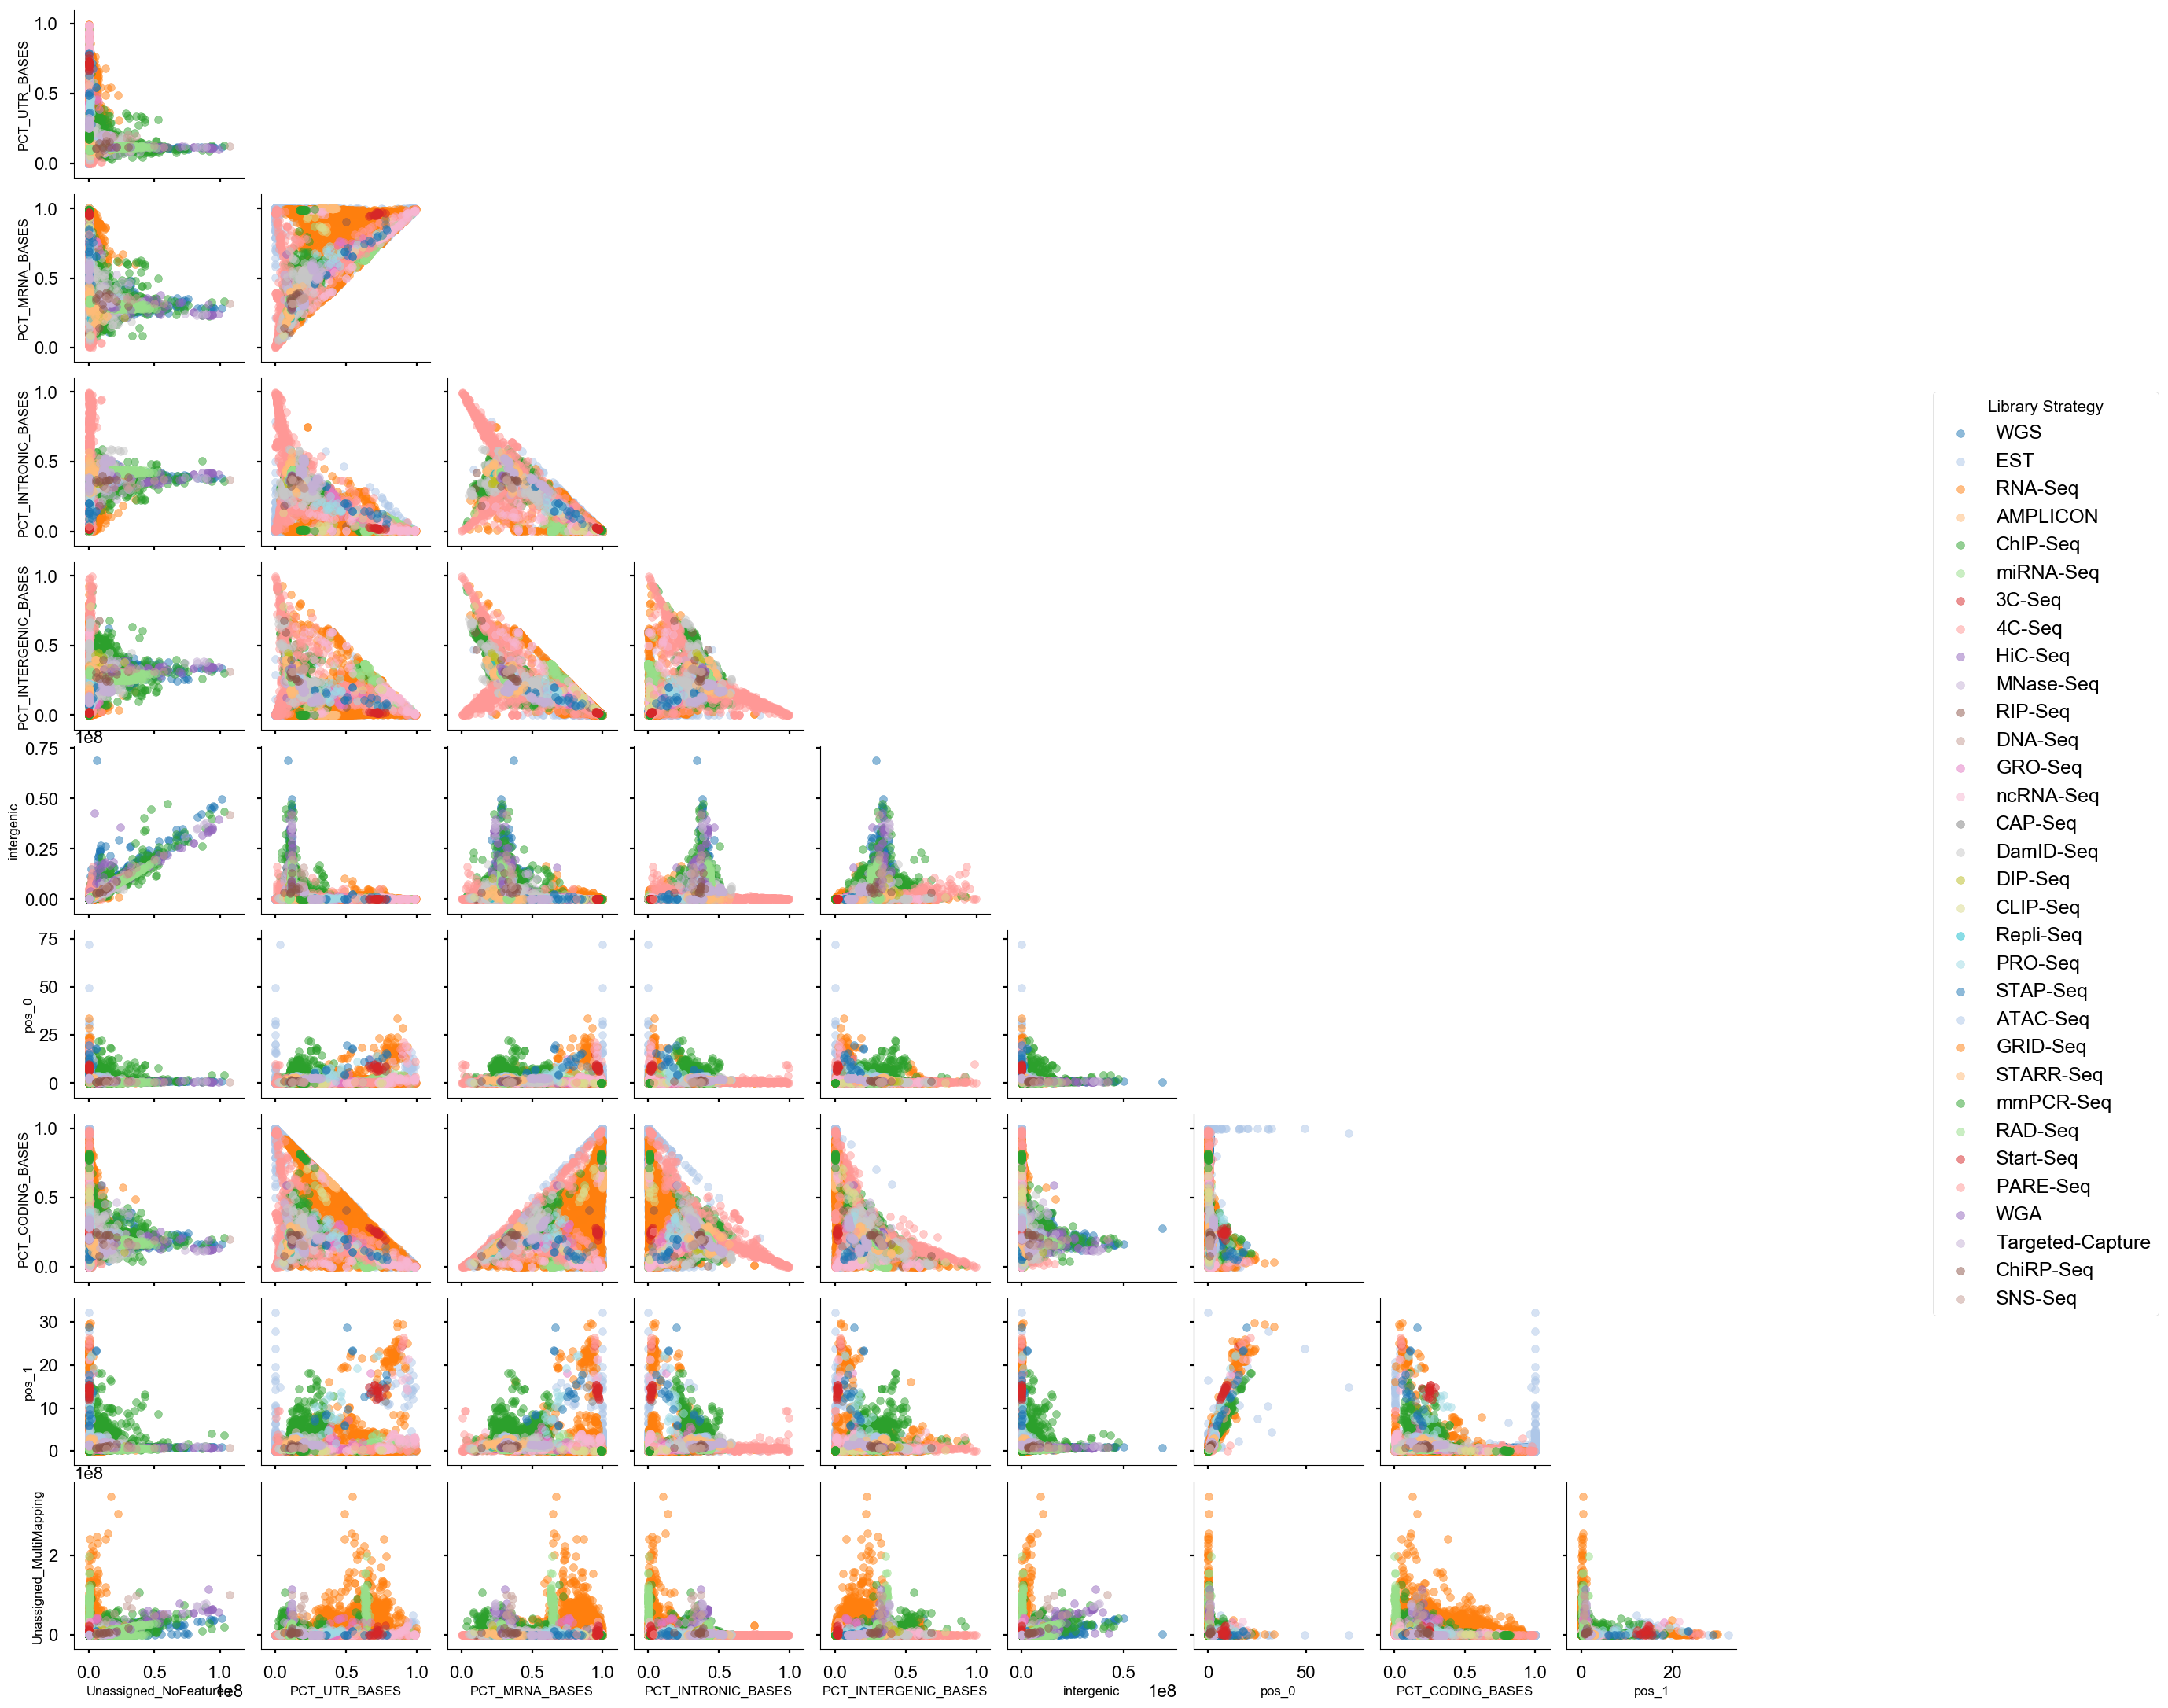

In [11]:
def plot(fname='../output/notebook/2019-02-21_lib_strategy_features.svg', force=False):
    if check(fname, force):
        return 
    
    g = (
        sns.PairGrid(df, hue='strategy', palette='tab20')
        .map_lower(plt.scatter, s=50, alpha=.5, rasterized=True)
        .add_legend(fontsize=18, title='Library Strategy')
    )

    # Resize Y and X labels
    for ax in g.axes[:, 0]:
        ax.set_ylabel(ax.get_ylabel(), fontsize=12)

    for ax in g.axes[-1, :]:
        ax.set_xlabel(ax.get_xlabel(), fontsize=12)

    # Remove upper traingle
    for r, c in zip(*np.triu_indices(g.axes.shape[0])):
        g.axes[r, c].set_visible(False)

    # Move plots closer
    plt.subplots_adjust(hspace=.1, wspace=.1)

    g.savefig(fname, bbox_inches='tight')
    
plot(force=True)

In [12]:
mapper = {
    'RNA-Seq': "Expression",
    'EST': "Expression",
    'ChIP-Seq': "Genome",
    'WGS': "Genome",
}

subset = (
    df
    .query('strategy == ["RNA-Seq", "EST", "ChIP-Seq", "WGS"]')
    .assign(strategy = lambda df: df.strategy.map(mapper))
)

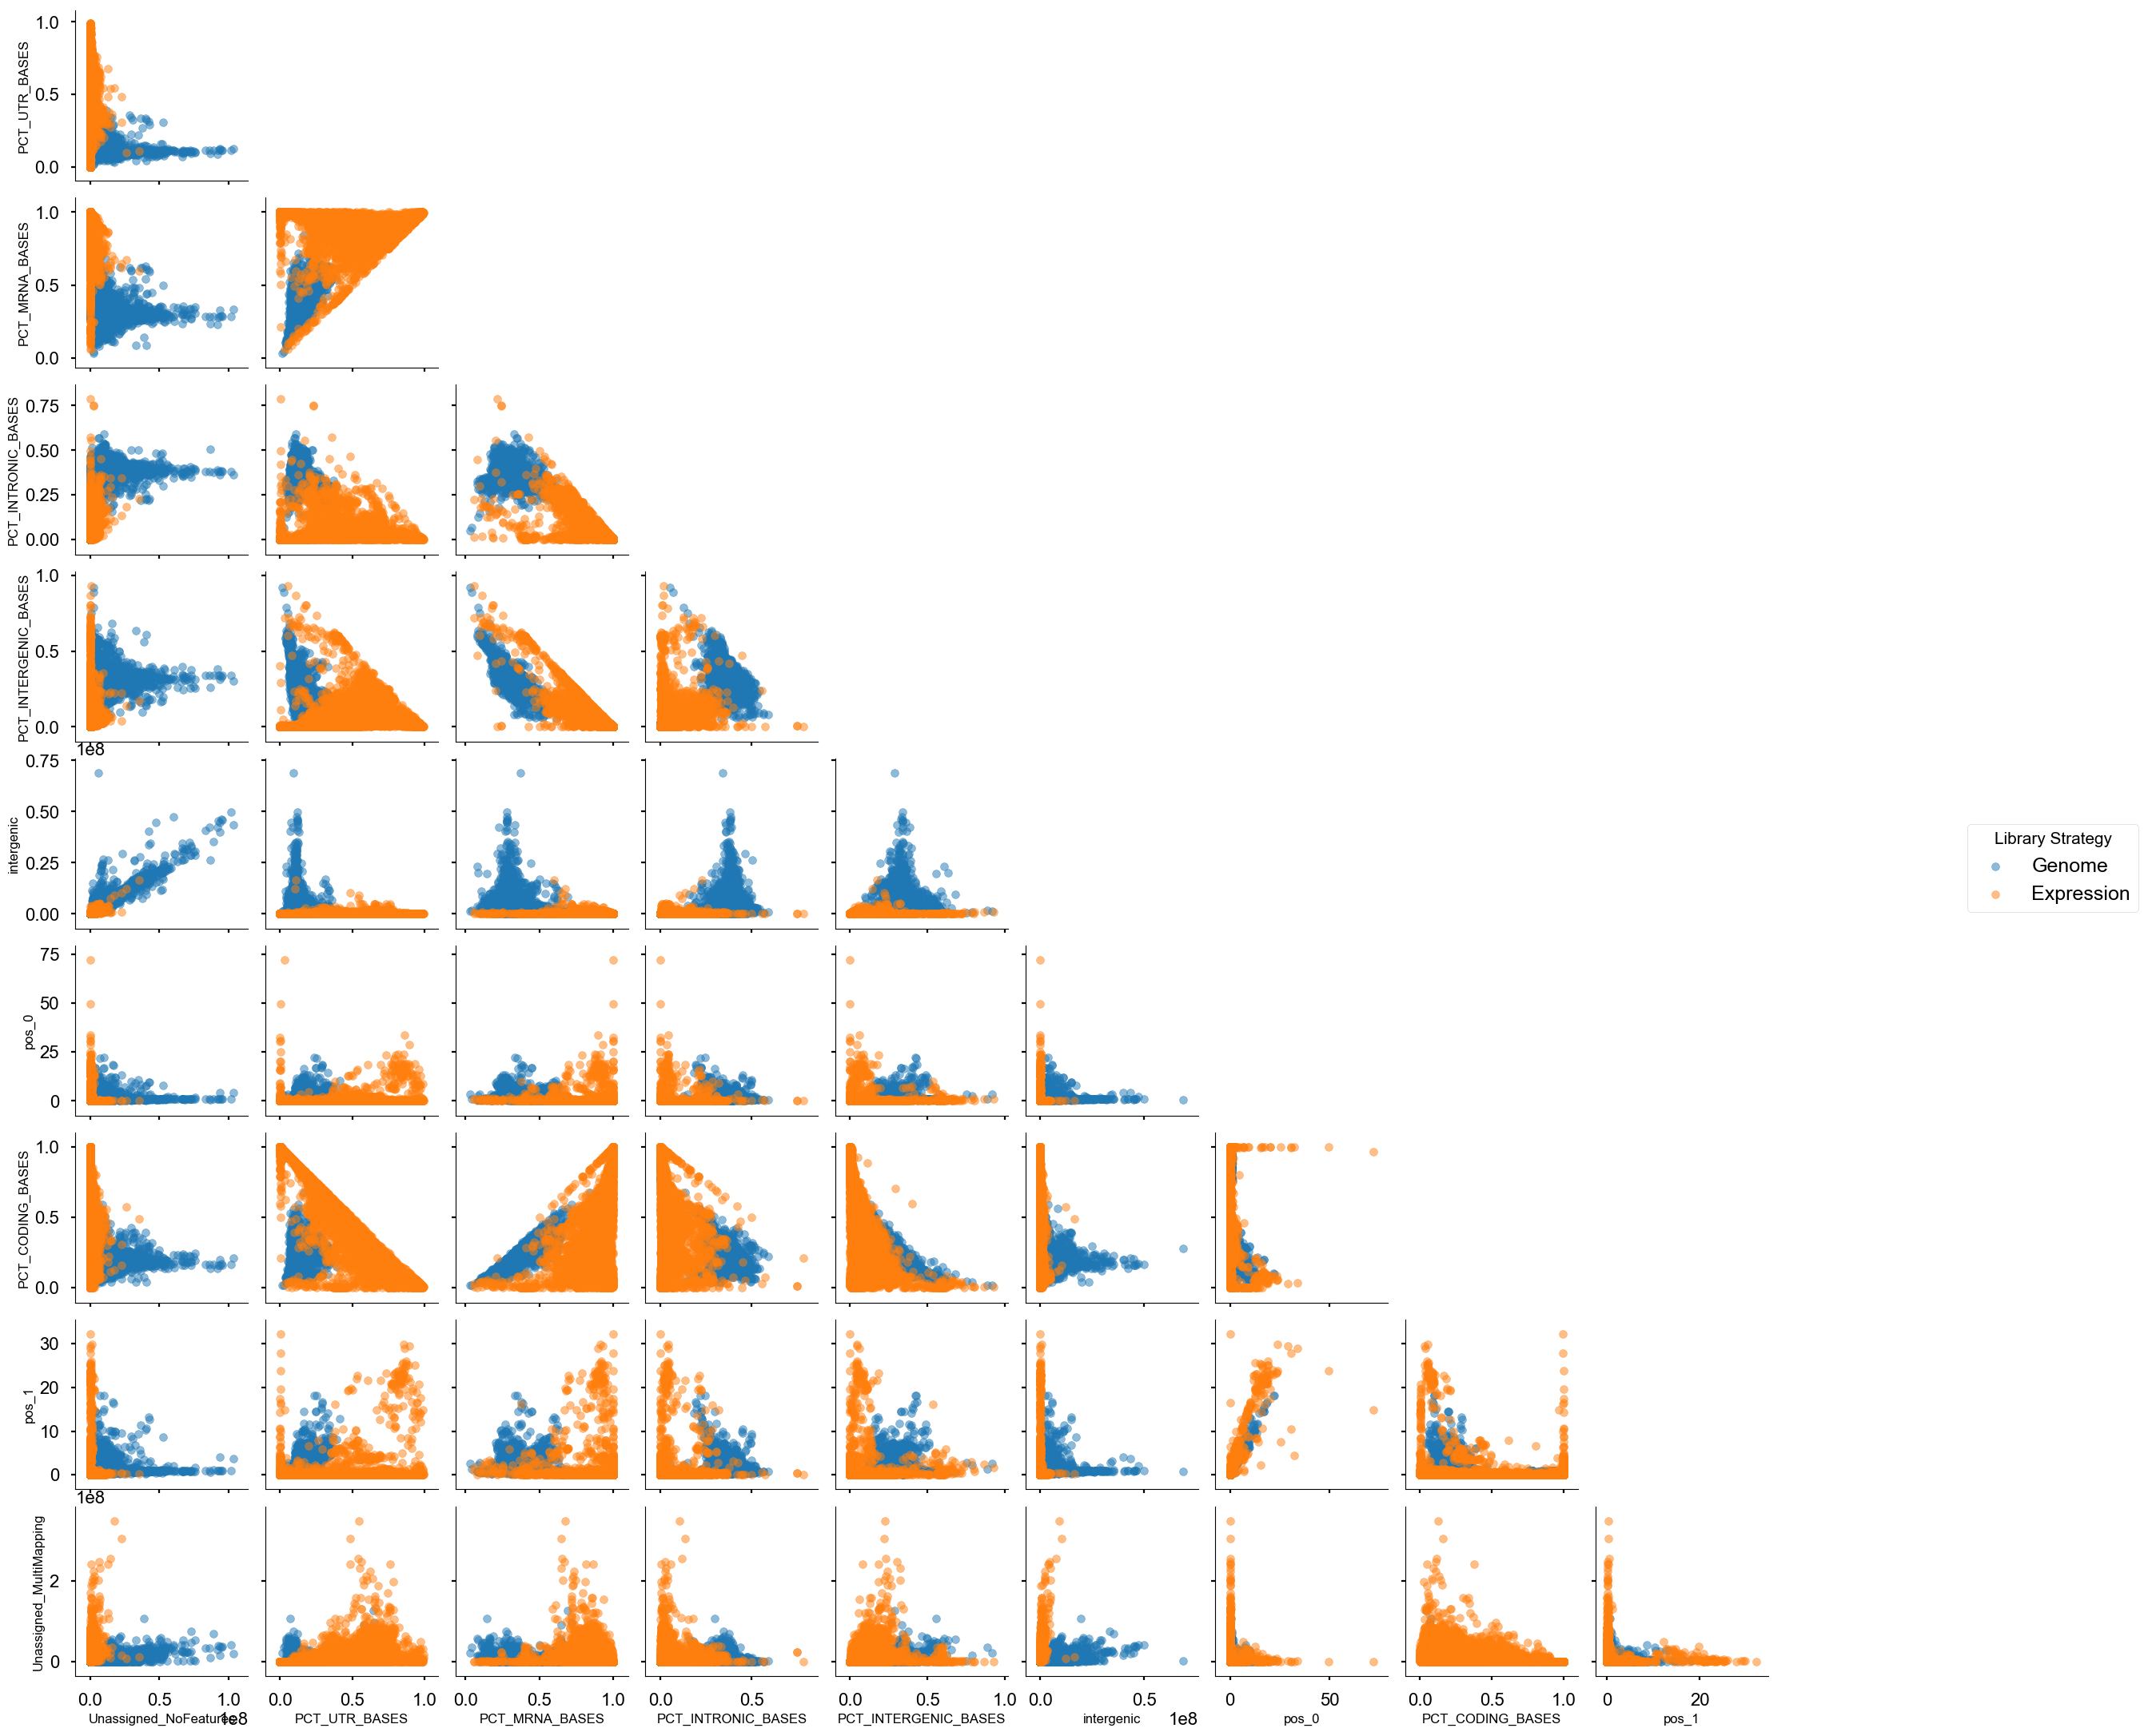

In [13]:
g = (
    sns.PairGrid(subset, hue='strategy', palette='tab10')
    .map_lower(plt.scatter, s=50, alpha=.5, rasterized=True)
    .add_legend(fontsize=18, title='Library Strategy')
)

# Resize Y and X labels
for ax in g.axes[:, 0]:
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)

for ax in g.axes[-1, :]:
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)

# Remove upper traingle
for r, c in zip(*np.triu_indices(g.axes.shape[0])):
    g.axes[r, c].set_visible(False)

# Move plots closer
plt.subplots_adjust(hspace=.1, wspace=.1)

In [14]:
def jointplot_w_hue(data, x, y, hue=None, colormap = None, 
                    figsize = None, fig = None, scatter_kws=None):
    #defaults
    if colormap is None:
        colormap = sns.color_palette() #['blue','orange']
    if figsize is None:
        figsize = (5,5)
    if fig is None:
        fig  = plt.figure(figsize = figsize)
    if scatter_kws is None:
        scatter_kws = dict(alpha=0.4, lw=1)
        
    # derived variables
    if hue is None:
        return "use normal sns.jointplot"
    hue_groups = data[hue].unique()

    subdata = dict()
    colors = dict()
    
    active_colormap = colormap[0: len(hue_groups)]
    legend_mapping = []
    for hue_grp, color in zip(hue_groups, active_colormap):
        legend_entry = mpatches.Patch(color=color, label=hue_grp)
        legend_mapping.append(legend_entry)
        
        subdata[hue_grp] = data[data[hue]==hue_grp]
        colors[hue_grp] = color
        
    # canvas setup
    grid = gridspec.GridSpec(2, 2,
                           width_ratios=[4, 1],
                           height_ratios=[1, 4],
                           hspace = 0, wspace = 0
                           )
    ax_main = plt.subplot(grid[1,0])
    ax_xhist = plt.subplot(grid[0,0], sharex=ax_main)
    ax_yhist = plt.subplot(grid[1,1])#, sharey=ax_main)
    
    ## plotting
   
    # histplot x-axis
    for hue_grp in hue_groups:
        sns.distplot(subdata[hue_grp][x], color = colors[hue_grp], ax = ax_xhist)

    # histplot y-axis
    for hue_grp in hue_groups:
        sns.distplot(subdata[hue_grp][y], color = colors[hue_grp], ax = ax_yhist, vertical=True) 

    # main scatterplot 
    # note: must be after the histplots else ax_yhist messes up
    for hue_grp in hue_groups:
        sns.regplot(data = subdata[hue_grp], fit_reg=False,
                    x = x, y = y, ax = ax_main, color = colors[hue_grp],
                    scatter_kws=scatter_kws
                   )        
        
    # despine
    for myax in [ax_yhist, ax_xhist]:
        sns.despine(ax = myax, bottom=False, top=True, left = False, right = True, trim = False)
        plt.setp(myax.get_xticklabels(), visible=False)
        plt.setp(myax.get_yticklabels(), visible=False)
    
    
    # topright 
    ax_legend = plt.subplot(grid[0,1])#, sharey=ax_main)
    plt.setp(ax_legend.get_xticklabels(), visible=False)
    plt.setp(ax_legend.get_yticklabels(), visible=False)

    ax_legend.legend(handles=legend_mapping)
    return dict(fig = fig, gridspec = grid)

In [15]:
mapper = {
    'RNA-Seq': "Expression",
    'EST': "Expression",
    'ChIP-Seq': "Genome",
    'WGS': "Genome",
}

subset = (
    features
    .join(strategy)
    .query('strategy == ["RNA-Seq", "EST", "ChIP-Seq", "WGS"]')
    .assign(strategy = lambda df: df.strategy.map(mapper))
)

/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/fearjm/miniconda3/envs/ncbi_remap/lib/pyt

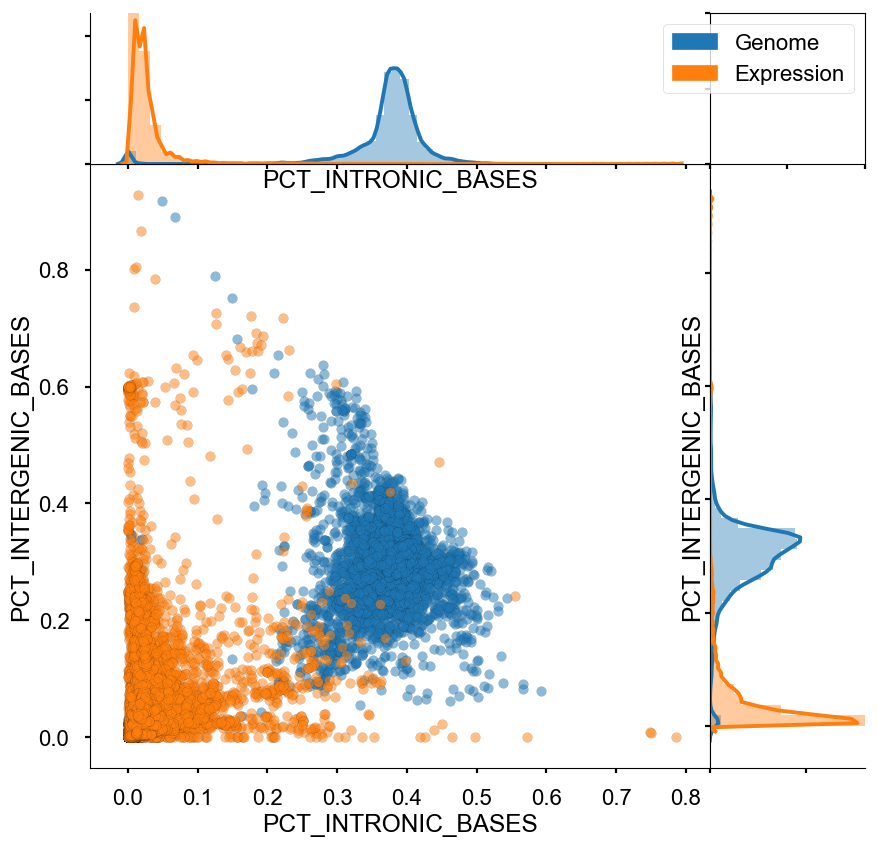

In [16]:
g = jointplot_w_hue(subset, 'PCT_INTRONIC_BASES', 'PCT_INTERGENIC_BASES', 
                    hue='strategy', colormap=sns.color_palette('tab10'),
                    figsize=(10, 10), scatter_kws=dict(s=50, alpha=.5, edgecolor='k', lw=.1, rasterized=True)
                   )
plt.savefig('../output/notebook/2019-02-21_lib_strategy_intron_inter.svg', bbox_inches='tight')

In [17]:
subset = (
    df
    .query('strategy == ["RNA-Seq", "EST"]')
)

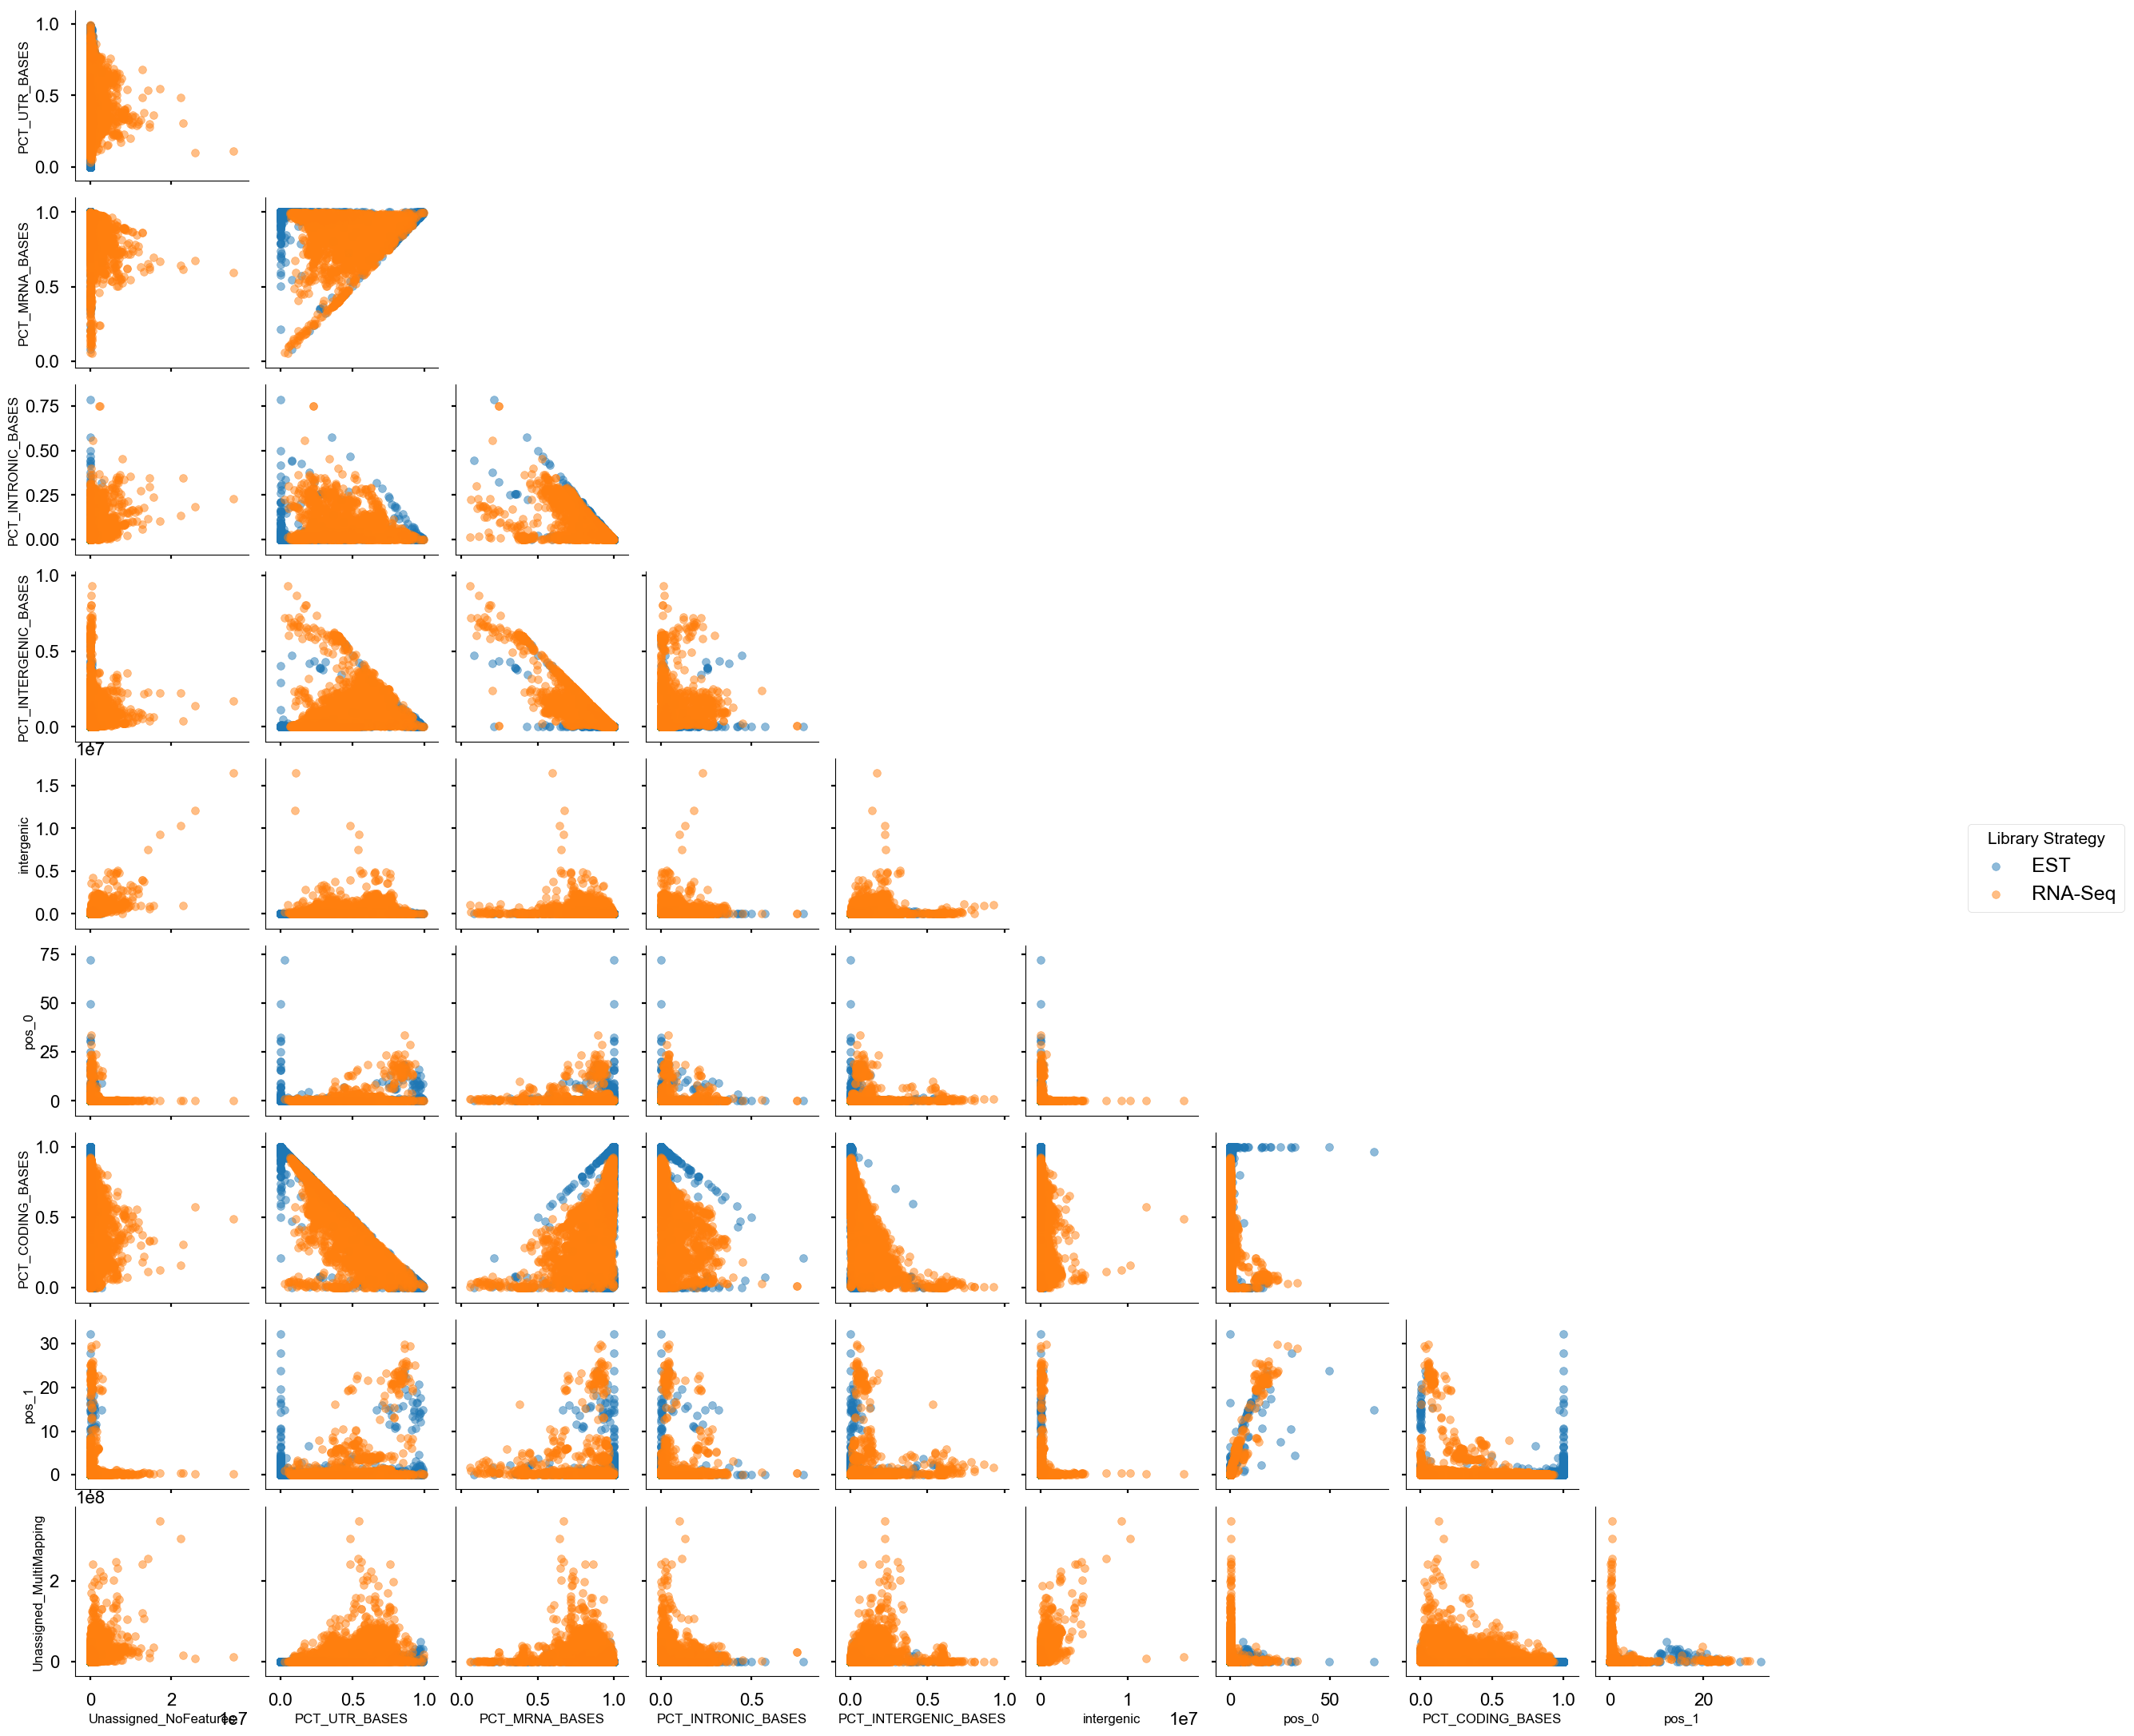

In [18]:
g = (
    sns.PairGrid(subset, hue='strategy', palette='tab10')
    .map_lower(plt.scatter, s=50, alpha=.5, rasterized=True)
    .add_legend(fontsize=18, title='Library Strategy')
)

# Resize Y and X labels
for ax in g.axes[:, 0]:
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)

for ax in g.axes[-1, :]:
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)

# Remove upper traingle
for r, c in zip(*np.triu_indices(g.axes.shape[0])):
    g.axes[r, c].set_visible(False)

# Move plots closer
plt.subplots_adjust(hspace=.1, wspace=.1)

In [19]:
subset = (
    features
    .join(strategy)
    .query('strategy == ["RNA-Seq", "EST"]')
)

/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/fearjm/miniconda3/envs/ncbi_remap/lib/pyt

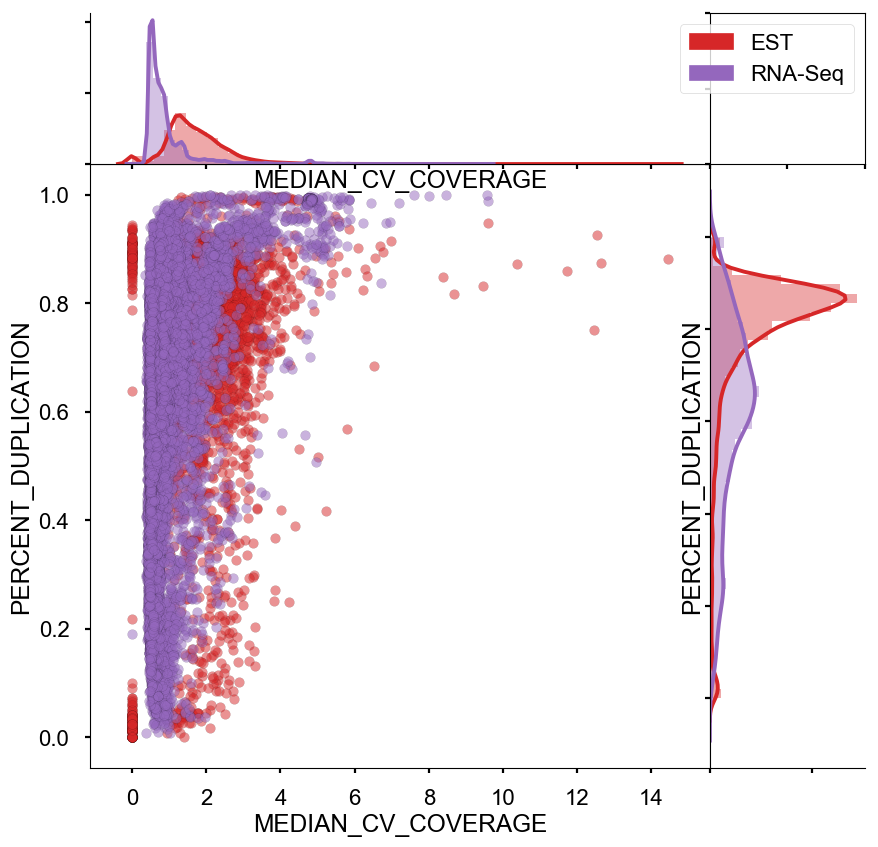

In [20]:
g = jointplot_w_hue(subset, 'MEDIAN_CV_COVERAGE', 'PERCENT_DUPLICATION', 
                    hue='strategy', colormap=sns.color_palette('tab10', n_colors=10)[3:5],
                    figsize=(10, 10), scatter_kws=dict(s=50, alpha=.5, edgecolor='k', lw=.1, rasterized=True)
                   )
plt.savefig('../output/notebook/2019-02-21_lib_strategy_dup_cv.svg', bbox_inches='tight')

In [21]:
strategy = (
    pd.read_parquet('../output/metadata-wf/select_library_strategy.parquet')
    .rename({'Fear_et_al_library_strategy': 'strategy'}, axis=1)
    .strategy
    .pipe(lambda x: x[~x.str.contains('\|')])
    .value_counts()
    .rename('SRXs')
    .to_frame()
    .reset_index()
    .rename(columns={'index': 'strategy'})
)

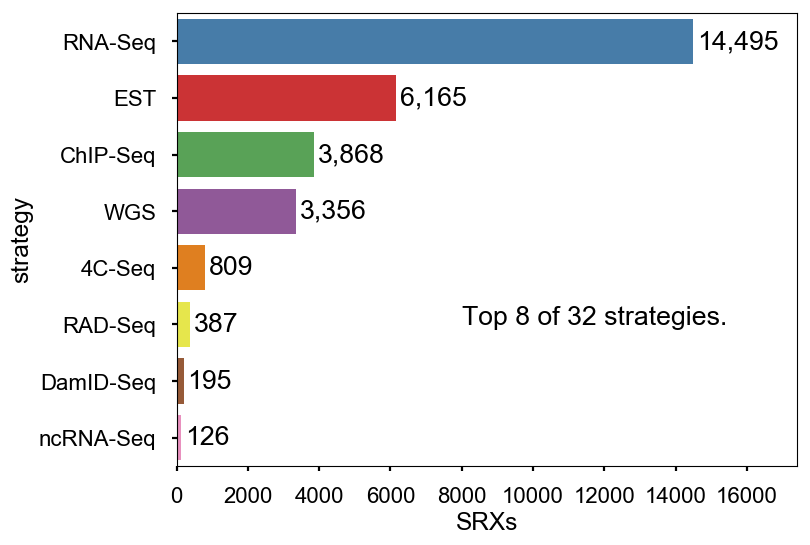

In [22]:
ax = sns.barplot('SRXs', 'strategy', data=strategy.head(8))
for i, row in strategy.head(8).iterrows():
    ax.text(row.SRXs + 100, i, f'{row.SRXs:,}', ha='left', va='center')
ax.text(8_000, 5, f'Top 8 of {strategy.shape[0]} strategies.')
ax.margins(.2)
plt.savefig('../output/notebook/2019-02-21_lib_strategy_counts.svg')